# **Localization of a Vegetarian Restaurant in Mexico**

#### By: **Daniel Eduardo López**

Final Project for the module of Machine Learning 
##### **Master in Data Science & Artificial Intelligence** at <a href="https://www.devf.la/master/data/mx">DEV.F</a>
_____




### **1. Goal**
To define the appropriate location of a Vegetarian Restaurant in Mexico through the use of Machine Learning techniques.

### **2. Instructions**
1. Using demographic variables, perform a supervised model where the target variable is the number of restaurants.
2. Create the independent variables using the State and the ZIP code as primary/foreign keys.
3. Use at least 50 variables and with some of them develop an unsupervised model using K-Means to profile each of the ZIP Codes.
4. Train a model using a clustering technique and the rest of the variables to predict the target Variable (use Grid Search and Cross Validation).
5. Determine 10 locations where the restaurant might be placed.
6. Determine the 5 most influential variables.
7. Present your results on Google Slides.



### **3. Data collection**

Data was collected from the **National Institute of Statistics and Geography** (INEGI, in Spanish) through its <a href="https://www.inegi.org.mx/servicios/api_denue.html">API</a> and some static files. In particular, the **National Statistical Directory of Economic Units** and the **Bank of Indicators** were used along with the **Gross Domestic Product** for each Mexican state.

In [321]:
# Libraries importation
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.model_selection import (                            
                                      train_test_split,
                                      GridSearchCV
                                      )
import time
%matplotlib inline

In [2]:
# Setting of the Seaborn theme to Darkgrid
sns.set_theme(context = 'notebook', style = 'darkgrid')

In [12]:
# INEGI's API Token
token = "06bf4cf2-9d80-47a5-9317-1c5d2a59b0e7" # JC

In [4]:
# Setting of the INEGI's API to get Restaurants' information

def radio_search_inegi(condition="restaurantes", radio=500, loc=[19.4339339,-99.135982]):
    """
    The purpose of this function is to retrieve businesses data from the INEGI's API, such as name, economic activity, location, etc.  
    """
    lat, lng = loc
    
    url = f"https://www.inegi.org.mx/app/api/denue/v1/consulta/buscar/{condition}/{lat},{lng}/{radio}/{token}"
    
    time.sleep(0.48)
    r = requests.get(url)
    time.sleep(0.02)
    
    if r.status_code not in range(200, 300):
        return {}
    return r.json()

In [5]:
# Setting of the INEGI's API to get cuantify the number of businesses in a given location

def cuant_inegi(economic_act="43", geo_area="010010001", stratum = 0):
    """
    The purpose of this function is to cuantify the number of businesses from the INEGI's API for a given location and economic activity.  
    """
    url = f"https://www.inegi.org.mx/app/api/denue/v1/consulta/Cuantificar/{economic_act}/{geo_area}/{stratum}/{token}"
    
    time.sleep(0.48)
    r = requests.get(url)
    time.sleep(0.02)
    
    if r.status_code not in range(200, 300):
        return {}
    return r.json()

In [69]:
# Setting of the INEGI's API to get the latest macroeconomic information of a given location

def indicator_inegi(id_indicator="1002000001", geo_area="00", lang = "es", most_recent = "true", data_source = "BISE", version = "2.0", format = "json"):
    """
    The purpose of this function is to retrieve the value of a given economic or demographic indicatorfrom the INEGI's API.  
    """
    url = f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{id_indicator}/{lang}/{geo_area}/{most_recent}/{data_source}/{version}/{token}?type={format}"
    time.sleep(0.48)
    r = requests.get(url)
    time.sleep(0.02)

    if r.status_code == 204: #No content
      return None
    
    if r.status_code not in range(200, 300):
      return {}

    return r.json()

In [7]:
# Dictionary of the Mexican States and the location (lat, long) of their capitals.
states_lat_long_dict = {'Aguascalientes': (21.87945992,	-102.2904135),
                  'Baja California': (32.663214,-115.4903741),
                  'Baja California Sur': (24.1584937,-110.315928),
                  'Campeche': (19.8450352,-90.5381231),
                  'Chiapas': (16.7541485,-93.119001),
                  'Chihuahua': (28.6349557,-106.0777049),
                  'Coahuila': (25.4286965,-100.9994484),
                  'Colima': (19.2408324,-103.7291389),
                  'Ciudad de México': (19.4335493,-99.1344048),
                  'Durango': (24.0241017,-104.6708325),
                  'Guanajuato': (21.0176446,-101.2586863),
                  'Guerrero': (17.5516921,-99.5025877),
                  'Hidalgo': (20.1183855,-98.7540094),
                  'Jalisco': (20.6773775,-103.3494204),
                  'Estado de México': (19.289191,-99.6670425),
                  'Michoacán': (19.7030535,-101.1937953),
                  'Morelos': (18.9218499,-99.2353856),
                  'Nayarit': (21.5122308,-104.8948845),
                  'Nuevo León': (25.6717637,-100.3163831),
                  'Oaxaca': 	(17.0617935,-96.7271634),
                  'Puebla': (19.0428817,-98.2002919),
                  'Querétaro': (20.37998212,	-100.0000308),
                  'Quintana Roo': (18.4978052,-88.3029951),
                  'San Luis Potosí': (22.1521646,-100.9765552),
                  'Sinaloa': (24.8082702,-107.3945828),
                  'Sonora': (29.0748734,-110.9597578),
                  'Tabasco': (17.9882632,-92.9209807),
                  'Tamaulipas': (23.7312703,-99.1517694),
                  'Tlaxcala': (19.3171271,-98.2386354),
                  'Veracruz': (19.5269375,-96.92401),
                  'Yucatán': (20.9664386,-89.623114),
                  'Zacatecas': (22.7753476,-102.5740002)} # Own elaboration
                
states_lat_long = pd.DataFrame.from_dict(states_lat_long_dict, orient='index').reset_index().\
                    rename(columns={"index": "State", 0: "Lat", 1: "Long"}).set_index('State')
states_lat_long.head()

,Lat,Long
State,,
Aguascalientes,21.879460,-102.290413
Baja California,32.663214,-115.490374
Baja California Sur,24.158494,-110.315928
Campeche,19.845035,-90.538123
Chiapas,16.754148,-93.119001


In [ ]:
# Restaurants in Aguascalientes
restaurants = radio_search_inegi('restaurantes',loc=[21.87945992,	-102.2904135])
df = pd.DataFrame(restaurants)
df['State'] = 'Aguascalientes'
df.head()

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,CentroComercial,TipoCentroComercial,NumLocal,State
0,01001722514008101000000000U2,7702727,LONCHERIA EL VAQUERO,,Restaurantes con servicio de preparación de ta...,0 a 5 personas,CALLE,WASCO,114,0,...,4491125120,,,Fijo,-102.29065083,21.87998632,,,,Aguascalientes
1,01001722514008801000000000U7,6924209,LONCHERIA RYK,,Restaurantes con servicio de preparación de ta...,0 a 5 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS PONIENTE,401,0,...,,,,Fijo,-102.29155423,21.87907014,,,,Aguascalientes
2,01001722212001051000000000U7,20688,TACOS AVENIDA,,Restaurantes con servicio de preparación de ta...,0 a 5 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS PONIENTE,418,,...,,,,Fijo,-102.29168702,21.87924402,,,,Aguascalientes
3,01001722518003461000000000U6,6979709,COCINA ECONOMICA MICHELLE,,Restaurantes que preparan otro tipo de aliment...,0 a 5 personas,CALLE,JOSEFA ORTIZ DE DOMINGUEZ,249,0,...,4494004904,,,Fijo,-102.28910925,21.87944693,,,,Aguascalientes
4,01001722514003121000000000U5,23425,TACOS DE CANASTA SAR,,Restaurantes con servicio de preparación de ta...,0 a 5 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS PONIENTE,449,0,...,,,,Fijo,-102.28912148,21.87923838,,,,Aguascalientes


In [ ]:
# Restaurants in the other States of Mexico
for i, val in states_lat_long.iterrows():
  print(i)
  result = radio_search_inegi('restaurantes',loc=[val[0],	val[1]])
  dff = pd.DataFrame(result)
  dff['State'] = i
  df = pd.concat([df, dff])

df.info()

Aguascalientes
Baja California
Baja California Sur
Campeche
Chiapas
Chihuahua
Coahuila
Colima
Ciudad de México
Durango
Guanajuato
Guerrero
Hidalgo
Jalisco
Estado de México
Michoacán
Morelos
Nayarit
Nuevo León
Oaxaca
Puebla
Querétaro
Quintana Roo
San Luis Potosí
Sinaloa
Sonora
Tabasco
Tamaulipas
Tlaxcala
Veracruz
Yucatán
Zacatecas
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4922 entries, 0 to 141
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CLEE                 4922 non-null   object
 1   Id                   4922 non-null   object
 2   Nombre               4922 non-null   object
 3   Razon_social         4922 non-null   object
 4   Clase_actividad      4922 non-null   object
 5   Estrato              4922 non-null   object
 6   Tipo_vialidad        4922 non-null   object
 7   Calle                4922 non-null   object
 8   Num_Exterior         4922 non-null   object
 9   Num_Interior      

In [ ]:
df.to_csv('RestaurantsMX.csv', index = False)

In [81]:
# Dictionary of the Mexican States and the INEGI's codes of their capitals (INEGI, 2020).
geo_areas_codes = {'Aguascalientes': '010010001', # Aguascalientes (Capital city)
                  'Baja California': '020020001', # Mexicali
                  'Baja California Sur': '030030001', # La Paz
                  'Campeche': '040020001', # Campeche (Capital city)
                  'Chiapas': '071010001', # Tuxtla Gutiérrez
                  'Chihuahua': '080190001', # Chihuahua (Capital city)
                  'Coahuila': '050300001', # Saltillo
                  'Colima': '060020001', # Colima (Capital city)
                  'Ciudad de México': '090150001', # Alcaldía Cuauhtémoc
                  'Durango': '100050001',# Durango (Capital city)
                  'Guanajuato': '110150001', # Guanajuato (Capital city)
                  'Guerrero': '120290001', # Chilpancingo
                  'Hidalgo': '130480001', # Pachuca
                  'Jalisco': '140390001', # Guadalajara
                  'Estado de México': '151060001', # Toluca
                  'Michoacán': '160530001', # Morelia
                  'Morelos': '170070001', # Cuernavaca
                  'Nayarit': '180170001', # Tepic
                  'Nuevo León': '190390001', # Monterrey
                  'Oaxaca': '200670001', # Oaxaca (Capital city)
                  'Puebla': '211140001', # Puebla (Capital city)
                  'Querétaro': '220140001', # Querétaro (Capital city)
                  'Quintana Roo': '230040001', # Chetumal
                  'San Luis Potosí': '240280001', # San Luis Potosí (Capital city)
                  'Sinaloa': '250060001', # Culiacán
                  'Sonora': '260300001', # Hermosillo
                  'Tabasco': '270040001', # Villahermosa
                  'Tamaulipas': '280410001', # Ciudad Victoria
                  'Tlaxcala': '290330001', # Tlaxcala (Capital city)
                  'Veracruz': '300870001', # Xalapa
                  'Yucatán': '310500001', # Mérida
                  'Zacatecas': '320560001' # Tlaxcala (Capital city)
                  } # Own elaboration

# Dictionary of some selected economic activities and their INEGI's codes (INEGI, 2018).
economic_acts_codes = {
                      'Edificación residencial': 2361,
                      'Elaboración de azúcares, chocolates, dulces y similares': 3113,
                      'Conservación de frutas, verduras, guisos y otros alimentos preparados': 3114,
                      'Elaboración de productos lácteos': 3115,
                      'Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles': 3116,
                      'Preparación y envasado de pescados y mariscos': 3117,
                      'Elaboración de productos de panadería y tortillas': 3118,
                      'Otras industrias alimentarias': 3119,
                      'Industria de las bebidas': 3121,
                      'Industria del tabaco': 3122,
                      'Confección de prendas de vestir': 3152,
                      'Fabricación de calzado': 3162,
                      'Fabricación de productos farmacéuticos': 3254,
                      'Fabricación de jabones, limpiadores y preparaciones de tocador': 3256,
                      'Comercio al por mayor de abarrotes y alimentos': 4311,
                      'Comercio al por menor de abarrotes y alimentos ': 4611,
                      'Comercio al por menor de bebidas, hielo y tabaco': 4612,
                      'Comercio al por menor en tiendas de autoservicio': 4621,
                      'Comercio al por menor en tiendas departamentales': 4622,
                      'Comercio al por menor de ropa, bisutería y accesorios de vestir': 4632,
                      'Comercio al por menor de calzado': 4633,
                      'Comercio al por menor de artículos para el cuidado de la salud': 4641,
                      'Comercio al por menor de artículos de perfumería y joyería': 4651,
                      'Comercio al por menor de artículos para el esparcimiento': 4652,
                      'Comercio al por menor de artículos de papelería, libros, revistas y periódicos': 4653,
                      'Comercio al por menor de mascotas, regalos, artículos religiosos, desechables, artesanías y otros artículos de uso personal': 4659,
                      'Comercio al por menor de muebles para el hogar y otros enseres domésticos': 4661,
                      'Comercio al por menor de mobiliario, equipo y accesorios de cómputo, teléfonos y otros aparatos de comunicación': 4662,
                      'Comercio al por menor de artículos para la decoración de interiores': 4663,
                      'Comercio al por menor de artículos usados': 4664,
                      'Comercio al por menor de artículos de ferretería, tlapalería y vidrios': 4671,
                      'Comercio al por menor de automóviles y camionetas': 4681,
                      'Comercio al por menor de partes y refacciones para automóviles, camionetas y camiones': 4682,
                      'Comercio al por menor de combustibles, aceites y grasas lubricantes': 4684,
                      'Comercio al por menor exclusivamente a través de internet, y catálogos impresos, televisión y similares': 4691,
                      'Transporte aéreo regular': 4811,
                      'Transporte colectivo urbano y suburbano de pasajeros de ruta fija': 4851,
                      'Transporte colectivo foráneo de pasajeros de ruta fija': 4852,
                      'Servicio de taxis y limusina': 4853,
                      'Transporte escolar y de personal': 4854,
                      'Servicios de mensajería y paquetería foránea': 4921,
                      'Servicios de mensajería y paquetería local': 4922,
                      'Operadores de servicios de telecomunicaciones alámbricas e inalámbricas': 5173,
                      'Operadores de servicios de telecomunicaciones vía satélite': 5174,
                      'Procesamiento electrónico de información, hospedaje y otros servicios relacionados': 518,
                      'Banca central': 521,
                      'Instituciones de intermediación crediticia y financiera no bursátil': 522,
                      'Actividades bursátiles, cambiarias y de inversión financiera': 523,
                      'Compañías de seguros, fianzas, y administración de fondos para el retiro': 524,
                      'Servicios inmobiliarios': 531,
                      'Servicios de alquiler de bienes muebles': 532,
                      'Servicios profesionales, científicos y técnicos': 541,
                      'Servicios médicos de consulta externa y servicios relacionados': 621,
                      'Hospitales': 622,
                      'Servicios artísticos, culturales y deportivos, y otros servicios relacionados': 711,
                      'Museos, sitios históricos, zoológicos y similares': 712,
                      'Servicios de alojamiento temporal': 721,
                      'Servicios de preparación de alimentos y bebidas': 722,
                      'Asociaciones y organizaciones': 813,
                      } # Own elaboration


In [39]:
# Proof of concept
c = {'A':1, 'B':2, 'C':2}
n = {'Hola':1, 'Adios':2}
a = [[1 , 10, 5],[0,0,0]]

pd.DataFrame(a, columns = c.keys(), index = n.keys())

,A,B,C
Hola,1,10,5
Adios,0,0,0


In [40]:
# Cuantification of the number of businesses in the different Mexican States
%%timeit

data = []

for geo_areas_key, geo_areas_value in geo_areas_codes.items():
  print(f'Retrieving data for... {geo_areas_key}')
  number_econ_units = []

  for economic_acts_key, economic_acts_value in economic_acts_codes.items():
    
    result = int(cuant_inegi(economic_act = economic_acts_value, geo_area = geo_areas_value)[0]['Total'])

    if type(result) == int:
      number_econ_units.append(result)
    
    else:
      break
    
  data.append(number_econ_units)

df_units = pd.DataFrame(data, columns = economic_acts_codes.keys(), index = geo_areas_codes.keys())

df_units.head()

,Edificación residencial,"Elaboración de azúcares, chocolates, dulces y similares","Conservación de frutas, verduras, guisos y otros alimentos preparados",Elaboración de productos lácteos,"Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles",Preparación y envasado de pescados y mariscos,Elaboración de productos de panadería y tortillas,Otras industrias alimentarias,Industria de las bebidas,Industria del tabaco,...,Servicios inmobiliarios,Servicios de alquiler de bienes muebles,"Servicios profesionales, científicos y técnicos",Servicios médicos de consulta externa y servicios relacionados,Hospitales,"Servicios artísticos, culturales y deportivos, y otros servicios relacionados","Museos, sitios históricos, zoológicos y similares",Servicios de alojamiento temporal,Servicios de preparación de alimentos y bebidas,Asociaciones y organizaciones
Aguascalientes,122,28,15,190,17,0,728,71,136,0,...,597,241,1440,2291,31,62,14,129,6136,566
Baja California,51,3,7,40,5,1,510,29,232,0,...,418,245,860,1525,51,31,6,85,3252,752
Baja California Sur,68,2,2,37,6,1,233,8,98,0,...,187,91,437,563,20,26,8,82,1590,306
Campeche,40,10,1,21,4,2,276,27,49,0,...,102,76,332,523,17,18,11,103,1734,500
Chiapas,126,9,16,35,28,1,930,40,376,0,...,404,258,1000,1574,56,100,14,192,5378,1164


In [41]:
df_units.tail()

,Edificación residencial,"Elaboración de azúcares, chocolates, dulces y similares","Conservación de frutas, verduras, guisos y otros alimentos preparados",Elaboración de productos lácteos,"Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles",Preparación y envasado de pescados y mariscos,Elaboración de productos de panadería y tortillas,Otras industrias alimentarias,Industria de las bebidas,Industria del tabaco,...,Servicios inmobiliarios,Servicios de alquiler de bienes muebles,"Servicios profesionales, científicos y técnicos",Servicios médicos de consulta externa y servicios relacionados,Hospitales,"Servicios artísticos, culturales y deportivos, y otros servicios relacionados","Museos, sitios históricos, zoológicos y similares",Servicios de alojamiento temporal,Servicios de preparación de alimentos y bebidas,Asociaciones y organizaciones
Tamaulipas,40,3,6,12,7,1,281,9,162,0,...,156,72,302,461,19,20,7,53,1485,539
Tlaxcala,1,2,0,12,0,0,101,6,8,0,...,26,17,127,217,4,32,10,18,488,63
Veracruz,44,16,17,35,6,0,831,34,178,0,...,265,142,737,1526,20,46,13,137,3956,595
Yucatán,323,23,12,93,10,3,1090,60,162,1,...,610,412,1788,2731,48,89,30,313,7198,1052
Zacatecas,21,4,2,21,3,0,180,15,35,0,...,90,33,251,491,5,22,10,78,1116,191


In [42]:
df_units.to_csv('NumberEconUnitsPerState.csv')

In [98]:
# Dictionary of some selected demographic and macroeconomic indicators and their INEGI's codes (INEGI, 2018).
indicators_codes = {
                      'Grado promedio de escolaridad de la población de 15 y más años': 1005000038,
                      'Población ocupada con ingresos de hasta un salario mínimo - 15 años y más': 6200032080,
                      'Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más': 6200032092,
                      #'Tasa de crecimiento de Personal ocupado total. Sector privado y paraestatal': 6207129551, #No data available at State level
                      #'Usuarios de Internet que han realizado transacciones vía Internet como proporción del total de usuarios de Internet': 6206972696, #No data available at State level
                      #'Hogares con computadora como proporción del total de hogares. Porcentaje.': 6206972690, #No data available at State level
                      'Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo': 6207061361,
                      
                    }

In [99]:
# Retrieval of some demographic indicators for the different Mexican States

data = []

for geo_areas_key, geo_areas_value in geo_areas_codes.items():
  
  print(f'\nRetrieving data for... {geo_areas_key}')
  indicators = []
  state_code = str(geo_areas_value)[:2]
  
  for indicators_codes_key, indicators_codes_value in indicators_codes.items():
    
    result = indicator_inegi(id_indicator = indicators_codes_value, geo_area = state_code)

    if result == None:
      indicators.append(np.nan)
          
    else:
      result = float(result['Series'][0]['OBSERVATIONS'][0]['OBS_VALUE'])
      indicators.append(result) 

    #print(f'{indicators_codes_key}: {result}')

  data.append(indicators)

df_indicators = pd.DataFrame(data, columns = indicators_codes.keys(), index = geo_areas_codes.keys())



Retrieving data for... Aguascalientes
Grado promedio de escolaridad de la población de 15 y más años: 10.3491343202918
Población ocupada con ingresos de hasta un salario mínimo - 15 años y más: 110843.0
Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más: 9709.0
Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo: -0.16958838892371375

Retrieving data for... Baja California
Grado promedio de escolaridad de la población de 15 y más años: 10.2026545439928
Población ocupada con ingresos de hasta un salario mínimo - 15 años y más: 457342.0
Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más: 15470.0
Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo: 2.7878894642053353

Retrieving data for... Baja California Sur
Grado promedio de escolaridad de la población de 15 y más años: 10.3425484887369
Población ocupada con ingresos de hasta un salario mínimo - 1

In [100]:
df_indicators.head()

,Grado promedio de escolaridad de la población de 15 y más años,Población ocupada con ingresos de hasta un salario mínimo - 15 años y más,Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más,Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo
Aguascalientes,10.349134,110843.0,9709.0,-0.169588
Baja California,10.202655,457342.0,15470.0,2.787889
Baja California Sur,10.342548,84725.0,26611.0,2.892042
Campeche,9.625130,178031.0,9299.0,-6.579347
Chiapas,7.783218,1232846.0,14235.0,4.978611


In [101]:
df_indicators.tail()

,Grado promedio de escolaridad de la población de 15 y más años,Población ocupada con ingresos de hasta un salario mínimo - 15 años y más,Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más,Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo
Tamaulipas,10.092209,686664.0,25677.0,2.954969
Tlaxcala,9.833170,285716.0,4892.0,-0.009875
Veracruz,8.745629,1386227.0,34596.0,-0.101668
Yucatán,9.594718,473500.0,17236.0,-1.057478
Zacatecas,9.245563,236471.0,6985.0,0.352256


In [102]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Aguascalientes to Zacatecas
Data columns (total 4 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   Grado promedio de escolaridad de la población de 15 y más años                                    32 non-null     float64
 1   Población ocupada con ingresos de hasta un salario mínimo - 15 años y más                         32 non-null     float64
 2   Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más                       32 non-null     float64
 3   Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo  32 non-null     float64
dtypes: float64(4)
memory usage: 1.2+ KB


In [107]:
df_indicators.to_csv('IndicatorsPerState.csv')

In [106]:
# Reference: INEGI (2022)
df_pibe = pd.read_excel('https://github.com/DanielEduardoLopez/DEVF-MachineLearning/blob/main/PIBE.xlsx?raw=true')
df_pibe.head(15)

,Instituto Nacional de Estadística y Geografía (INEGI).,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Sistema de Cuentas Nacionales de México. Produ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PIB de las actividades económicas por entidad ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Concepto,2.003000e+03,2.004000e+03,2.005000e+03,2.006000e+03,2.007000e+03,2.008000e+03,2.009000e+03,2.010000e+03,2.011000e+03,2.012000e+03,2.013000e+03,2.014000e+03,2.015000e+03,2.016000e+03,2.017000e+03,2.018000e+03,2019R,2020R
4,Valores constantes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Millones de pesos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,______aB.1bP - Producto interno bruto,1.306172e+07,1.357382e+07,1.388707e+07,1.451131e+07,1.484383e+07,1.501358e+07,1.422000e+07,1.494779e+07,1.549533e+07,1.605972e+07,1.627719e+07,1.674105e+07,1.729236e+07,1.774724e+07,1.812226e+07,1.852004e+07,18483180.262,16993931.54
7,D.21-D.31 - Impuestos sobre los...,5.026134e+05,5.231279e+05,5.393506e+05,5.799235e+05,5.893617e+05,6.108211e+05,5.714514e+05,5.953940e+05,6.195370e+05,6.287311e+05,6.345672e+05,6.738922e+05,7.129446e+05,7.646889e+05,7.924520e+05,8.187794e+05,817121.024,709955.15
8,______aB.1bV - Valor agregado bruto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Estados Unidos Mexicanos,1.255911e+07,1.305069e+07,1.334772e+07,1.393138e+07,1.425446e+07,1.440276e+07,1.364855e+07,1.435240e+07,1.487580e+07,1.543099e+07,1.564262e+07,1.606716e+07,1.657941e+07,1.698255e+07,1.732981e+07,1.770126e+07,17666059.24,16283976.375


In [111]:
df_pibe = df_pibe.iloc[10:42][['Unnamed: 18']]

In [121]:
df_pibe['States'] = list(geo_areas_codes.keys())
df_pibe = df_pibe.set_index('States').rename(columns = {'Unnamed: 18': 'PIB2020'})
df_pibe.head(10)

,PIB2020
States,
Aguascalientes,204726.037
Baja California,553650.356
Baja California Sur,121985.608
Campeche,481994.49
Chiapas,535558.427
Chihuahua,101247.641
Coahuila,254356.257
Colima,538030.466
Ciudad de México,2856750.909


In [122]:
df_pibe.to_csv('PIBperState.csv')

### **4. Data Wrangling**
In this section, the collected datasets were cleaned and joined.

In [209]:
# Load of datasets
df_rest = pd.read_csv('https://raw.githubusercontent.com/DanielEduardoLopez/DEVF-MachineLearning/main/RestaurantsMX.csv')
df_units = pd.read_csv('https://raw.githubusercontent.com/DanielEduardoLopez/DEVF-MachineLearning/main/NumberEconUnitsPerState.csv')
df_pibe = pd.read_csv('https://raw.githubusercontent.com/DanielEduardoLopez/DEVF-MachineLearning/main/PIBperState.csv')
df_indicators = pd.read_csv('https://raw.githubusercontent.com/DanielEduardoLopez/DEVF-MachineLearning/main/IndicatorsPerState.csv')

In [210]:
df_rest.head()

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,CentroComercial,TipoCentroComercial,NumLocal,State
0,01001722514008101000000000U2,7702727,LONCHERIA EL VAQUERO,NaN,Restaurantes con servicio de preparación de ta...,0 a 5 personas,CALLE,WASCO,114.0,0.0,...,4.491125e+09,NaN,NaN,Fijo,-102.290651,21.879986,NaN,NaN,NaN,Aguascalientes
1,01001722514008801000000000U7,6924209,LONCHERIA RYK,NaN,Restaurantes con servicio de preparación de ta...,0 a 5 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS PONIENTE,401.0,0.0,...,NaN,NaN,NaN,Fijo,-102.291554,21.879070,NaN,NaN,NaN,Aguascalientes
2,01001722212001051000000000U7,20688,TACOS AVENIDA,NaN,Restaurantes con servicio de preparación de ta...,0 a 5 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS PONIENTE,418.0,NaN,...,NaN,NaN,NaN,Fijo,-102.291687,21.879244,NaN,NaN,NaN,Aguascalientes
3,01001722518003461000000000U6,6979709,COCINA ECONOMICA MICHELLE,NaN,Restaurantes que preparan otro tipo de aliment...,0 a 5 personas,CALLE,JOSEFA ORTIZ DE DOMINGUEZ,249.0,0.0,...,4.494005e+09,NaN,NaN,Fijo,-102.289109,21.879447,NaN,NaN,NaN,Aguascalientes
4,01001722514003121000000000U5,23425,TACOS DE CANASTA SAR,NaN,Restaurantes con servicio de preparación de ta...,0 a 5 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS PONIENTE,449.0,0.0,...,NaN,NaN,NaN,Fijo,-102.289121,21.879238,NaN,NaN,NaN,Aguascalientes


In [211]:
df_units.head()

,Unnamed: 0,Edificación residencial,"Elaboración de azúcares, chocolates, dulces y similares","Conservación de frutas, verduras, guisos y otros alimentos preparados",Elaboración de productos lácteos,"Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles",Preparación y envasado de pescados y mariscos,Elaboración de productos de panadería y tortillas,Otras industrias alimentarias,Industria de las bebidas,...,Servicios inmobiliarios,Servicios de alquiler de bienes muebles,"Servicios profesionales, científicos y técnicos",Servicios médicos de consulta externa y servicios relacionados,Hospitales,"Servicios artísticos, culturales y deportivos, y otros servicios relacionados","Museos, sitios históricos, zoológicos y similares",Servicios de alojamiento temporal,Servicios de preparación de alimentos y bebidas,Asociaciones y organizaciones
0,Aguascalientes,122,28,15,190,17,0,728,71,136,...,597,241,1440,2291,31,62,14,129,6136,566
1,Baja California,51,3,7,40,5,1,510,29,232,...,418,245,860,1525,51,31,6,85,3252,752
2,Baja California Sur,68,2,2,37,6,1,233,8,98,...,187,91,437,563,20,26,8,82,1590,306
3,Campeche,40,10,1,21,4,2,276,27,49,...,102,76,332,523,17,18,11,103,1734,500
4,Chiapas,126,9,16,35,28,1,930,40,376,...,404,258,1000,1574,56,100,14,192,5378,1164


In [212]:
df_units = df_units.rename(columns = {'Unnamed: 0': 'State'}).set_index('State')

In [213]:
df_pibe.head()

,States,PIB2020
0,Aguascalientes,204726.037
1,Baja California,553650.356
2,Baja California Sur,121985.608
3,Campeche,481994.490
4,Chiapas,535558.427


In [214]:
df_pibe = df_pibe.rename(columns = {'States': 'State'}).set_index('State')

In [215]:
df_indicators.head()

,Unnamed: 0,Grado promedio de escolaridad de la población de 15 y más años,Población ocupada con ingresos de hasta un salario mínimo - 15 años y más,Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más,Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo
0,Aguascalientes,10.349134,110843.0,9709.0,-0.169588
1,Baja California,10.202655,457342.0,15470.0,2.787889
2,Baja California Sur,10.342548,84725.0,26611.0,2.892042
3,Campeche,9.625130,178031.0,9299.0,-6.579347
4,Chiapas,7.783218,1232846.0,14235.0,4.978611


In [216]:
df_indicators = df_indicators.rename(columns = {'Unnamed: 0': 'State'}).set_index('State')

In [217]:
df_rest_perState = pd.DataFrame(df_rest['State'].value_counts()).rename(columns = {'State': 'Restaurants'})
df_rest_perState.head()

,Restaurants
Yucatán,349
Morelos,323
Oaxaca,276
Ciudad de México,264
Jalisco,262


In [218]:
df_rest['CP'] = df_rest['CP'].fillna(0).astype(int).astype(str)
df_CP_size = pd.DataFrame(df_rest['CP'].value_counts()).rename(columns = {'CP': 'Restaurants'})
df_CP_size.head()

,Restaurants
97000,349
62000,320
68000,276
64000,221
91000,210


In [219]:
df_CP_state = pd.DataFrame(df_rest.groupby(by = 'CP')['State'].first()).iloc[1:]
df_CP_state

,State
CP,
20000,Aguascalientes
20240,Aguascalientes
20259,Aguascalientes
21100,Baja California
23000,Baja California Sur
...,...
91000,Veracruz
91070,Veracruz
91080,Veracruz


In [220]:
df_CP = df_CP_state.join(df_CP_size, how = 'left').drop_duplicates(subset= 'State')
df_CP

,State,Restaurants
CP,,
20000,Aguascalientes,98
21100,Baja California,77
23000,Baja California Sur,88
24000,Campeche,53
25000,Coahuila,79
28000,Colima,69
29000,Chiapas,61
31000,Chihuahua,123
34000,Durango,165


In [221]:
df_CP = df_CP.reset_index().set_index('State')

In [222]:
df_rest_veg = df_rest.copy()
df_rest_veg['Vegetarian'] = df_rest_veg['Nombre'].apply(lambda x: True if 'VEG' in str(x) else False)

In [223]:
df_rest_veg[df_rest_veg['Vegetarian'] == True]

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,CentroComercial,TipoCentroComercial,NumLocal,State,Vegetarian
58,01001722511002641000000000U9,6979771,HOLYVEGAN,NaN,Restaurantes con servicio de preparación de al...,0 a 5 personas,CALLE,FRANCISCO G. HORNEDO,602.0,NaN,...,HOLYVEGAN602@GMAIL.COM,NaN,Fijo,-102.286473,21.881685,NaN,NaN,NaN,Aguascalientes,True
135,01001722511002641000000000U9,6979771,HOLYVEGAN,NaN,Restaurantes con servicio de preparación de al...,0 a 5 personas,CALLE,FRANCISCO G. HORNEDO,602.0,NaN,...,HOLYVEGAN602@GMAIL.COM,NaN,Fijo,-102.286473,21.881685,NaN,NaN,NaN,Aguascalientes,True
778,05030722219008952000000000U9,238883,OSTIONERIA LAS VEGAS,NaN,Restaurantes con servicio de preparación de pe...,0 a 5 personas,CALLE,GENERAL MANUEL PEREZ TREVIÑO,319.0,24.0,...,NaN,NaN,Fijo,-101.000904,25.424829,MERCADO JUAREZ,MERCADO PUBLICO,24,Coahuila,True
903,09015461130012712011000000U2,888065,LOS VEGETARIANOS RESTAURANTE MADERO,LECHUGAS Y ESPINACAS SA DE CV,Restaurantes con servicio de preparación de al...,11 a 30 personas,CALLE,FRANCISCO I. MADERO,56.0,NaN,...,LOSVEGETARIANOS@GMAIL.COM,NaN,Fijo,-99.135567,19.433379,NaN,NaN,NaN,Ciudad de México,True
1014,09015722515000601011000000U8,989342,RESTAURANTE VEGETARIANO,NETOS DO MAROLO,Restaurantes con servicio de preparación de al...,6 a 10 personas,CALLE,MOTOLINIA,31.0,NaN,...,NaN,NaN,Fijo,-99.137349,19.433174,SIN NOMBRE,EDIFICIO COMERCIAL Y DE SERVICIOS,6,Ciudad de México,True
1173,10005722219011091000000000U6,1110007,RESTAURANTE VEGETARIANO SAMADHI,NaN,Restaurantes con servicio de preparación de al...,0 a 5 personas,CALLE,CAPITAN PEDRO CELESTINO NEGRETE,403.0,NaN,...,NaN,NaN,Fijo,-104.669067,24.025934,NaN,NaN,NaN,Durango,True
2099,16053722511001821000000000U2,2630208,COMIDA VEGETARIANA Y DESAYUNOS VEGETALIA,NaN,Restaurantes con servicio de preparación de al...,0 a 5 personas,CALLE,ALLENDE,329.0,NaN,...,NaN,NaN,Fijo,-101.194627,19.701910,NaN,NaN,NaN,Michoacán,True
2122,16053722511002481000000000S4,8941327,VEGGIE TACO Y MAS,NaN,Restaurantes con servicio de preparación de al...,0 a 5 personas,CALLE,SANTIAGO TAPIA,153.0,12.0,...,NaN,NaN,Fijo,-101.193017,19.704730,LA CANTERA MERCADO GASTRONOMICO,MERCADO PUBLICO,12,Michoacán,True
2153,16053722518000062010000000U9,2611077,RESTAURANT SUPER VEGETARIANO,NaN,Restaurantes con servicio de preparación de al...,6 a 10 personas,CALLE,VALENTIN GOMEZ FARIAS,115.0,NaN,...,NaN,NaN,Fijo,-101.196119,19.704156,NaN,NaN,NaN,Michoacán,True
2554,17007722511002901000000000U6,7526265,FONDA LAS VEGUITAS,NaN,Restaurantes con servicio de preparación de al...,0 a 5 personas,CALLE,NINGUNO,NaN,NaN,...,NaN,NaN,Fijo,-99.232629,18.925467,CENTRO COMERCIAL ADOLFO LOPEZ MATEOS,MERCADO PUBLICO,1257 1258,Morelos,True


In [224]:
df_rest_veg_count = pd.DataFrame(df_rest_veg[df_rest_veg['Vegetarian'] == True]['State'].value_counts()).rename(columns = {'State': 'VegetarianRests'})
df_rest_veg_count

,VegetarianRests
Michoacán,3
Aguascalientes,2
Ciudad de México,2
Coahuila,1
Durango,1
Morelos,1
Nayarit,1
Puebla,1
San Luis Potosí,1
Tlaxcala,1


In [225]:
df = (df_units.join(df_pibe, how = 'left').
      join(df_indicators, how = 'left').
      join(df_CP, how = 'left').
      join(df_rest_veg_count, how = 'left').fillna(0))
df.head()

,Edificación residencial,"Elaboración de azúcares, chocolates, dulces y similares","Conservación de frutas, verduras, guisos y otros alimentos preparados",Elaboración de productos lácteos,"Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles",Preparación y envasado de pescados y mariscos,Elaboración de productos de panadería y tortillas,Otras industrias alimentarias,Industria de las bebidas,Industria del tabaco,...,Servicios de preparación de alimentos y bebidas,Asociaciones y organizaciones,PIB2020,Grado promedio de escolaridad de la población de 15 y más años,Población ocupada con ingresos de hasta un salario mínimo - 15 años y más,Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más,Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo,CP,Restaurants,VegetarianRests
State,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,122,28,15,190,17,0,728,71,136,0,...,6136,566,204726.037,10.349134,110843.0,9709.0,-0.169588,20000,98,2.0
Baja California,51,3,7,40,5,1,510,29,232,0,...,3252,752,553650.356,10.202655,457342.0,15470.0,2.787889,21100,77,0.0
Baja California Sur,68,2,2,37,6,1,233,8,98,0,...,1590,306,121985.608,10.342548,84725.0,26611.0,2.892042,23000,88,0.0
Campeche,40,10,1,21,4,2,276,27,49,0,...,1734,500,481994.490,9.625130,178031.0,9299.0,-6.579347,24000,53,0.0
Chiapas,126,9,16,35,28,1,930,40,376,0,...,5378,1164,535558.427,7.783218,1232846.0,14235.0,4.978611,29000,61,0.0


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Aguascalientes to Zacatecas
Data columns (total 67 columns):
 #   Column                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                       --------------  -----  
 0   Edificación residencial                                                                                                      32 non-null     int64  
 1   Elaboración de azúcares, chocolates, dulces y similares                                                                      32 non-null     int64  
 2   Conservación de frutas, verduras, guisos y otros alimentos preparados                                                        32 non-null     int64  
 3   Elaboración de productos lácteos                                                                           

In [227]:
df['VegetarianRests'] = df['VegetarianRests'].astype(np.int64)

In [228]:
df.to_csv('FinalDataset.csv')

### **5. Feature Engineering**
In this section, the cleaned dataset was transformed into new variables more suitable for the later Machine Learning modeling.

In [229]:
df.head()

,Edificación residencial,"Elaboración de azúcares, chocolates, dulces y similares","Conservación de frutas, verduras, guisos y otros alimentos preparados",Elaboración de productos lácteos,"Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles",Preparación y envasado de pescados y mariscos,Elaboración de productos de panadería y tortillas,Otras industrias alimentarias,Industria de las bebidas,Industria del tabaco,...,Servicios de preparación de alimentos y bebidas,Asociaciones y organizaciones,PIB2020,Grado promedio de escolaridad de la población de 15 y más años,Población ocupada con ingresos de hasta un salario mínimo - 15 años y más,Población ocupada con ingresos de más de 5 salarios mínimos - 15 años y más,Indicador Trimestral de la Actividad Económica Estatal: Variación % respecto al trimestre previo,CP,Restaurants,VegetarianRests
State,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,122,28,15,190,17,0,728,71,136,0,...,6136,566,204726.037,10.349134,110843.0,9709.0,-0.169588,20000,98,2
Baja California,51,3,7,40,5,1,510,29,232,0,...,3252,752,553650.356,10.202655,457342.0,15470.0,2.787889,21100,77,0
Baja California Sur,68,2,2,37,6,1,233,8,98,0,...,1590,306,121985.608,10.342548,84725.0,26611.0,2.892042,23000,88,0
Campeche,40,10,1,21,4,2,276,27,49,0,...,1734,500,481994.490,9.625130,178031.0,9299.0,-6.579347,24000,53,0
Chiapas,126,9,16,35,28,1,930,40,376,0,...,5378,1164,535558.427,7.783218,1232846.0,14235.0,4.978611,29000,61,0


In [239]:
dff = df.copy()
dff = pd.get_dummies(dff, prefix='CP', prefix_sep='_', drop_first=True).rename(columns = {'VegetarianRests': 'Target'})
dff.head()

,Edificación residencial,"Elaboración de azúcares, chocolates, dulces y similares","Conservación de frutas, verduras, guisos y otros alimentos preparados",Elaboración de productos lácteos,"Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles",Preparación y envasado de pescados y mariscos,Elaboración de productos de panadería y tortillas,Otras industrias alimentarias,Industria de las bebidas,Industria del tabaco,...,CP_77000,CP_78000,CP_80000,CP_83000,CP_86000,CP_87000,CP_90000,CP_91000,CP_97000,CP_98000
State,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,122,28,15,190,17,0,728,71,136,0,...,0,0,0,0,0,0,0,0,0,0
Baja California,51,3,7,40,5,1,510,29,232,0,...,0,0,0,0,0,0,0,0,0,0
Baja California Sur,68,2,2,37,6,1,233,8,98,0,...,0,0,0,0,0,0,0,0,0,0
Campeche,40,10,1,21,4,2,276,27,49,0,...,0,0,0,0,0,0,0,0,0,0
Chiapas,126,9,16,35,28,1,930,40,376,0,...,0,0,0,0,0,0,0,0,0,0


### **6. Modeling**
In this section, data was modeled using both supervised and unsupervised learning techniques. 

In particular, **K-means modeling** was also used to create clusters and profile each of the ZIP Codes.

Then, a **linear regression model** was used to predict the number of vegetarian restaurants.

#### **6.1 Pre-processing**

In [246]:
X = dff.drop(columns = 'Target').values
y = dff['Target'].values

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = 0.20)

In [261]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_s = scaler.transform(X)

#### **6.2 Clustering with K-Means**

In [262]:
inertias = {k: KMeans(n_clusters=k, init = 'k-means++').fit(X_s).inertia_ for k in range(1, 15)}
inertias

{1: 18249362972115.145,
 2: 7426252652724.774,
 3: 4182834398283.453,
 4: 2612723865579.6406,
 5: 1691611439214.9404,
 6: 1011461446596.0726,
 7: 718588037506.7042,
 8: 485148067766.8999,
 9: 370435814959.2195,
 10: 306111875544.38776,
 11: 252740649698.84308,
 12: 196045743936.06152,
 13: 165668939182.30453,
 14: 125225061180.18095}

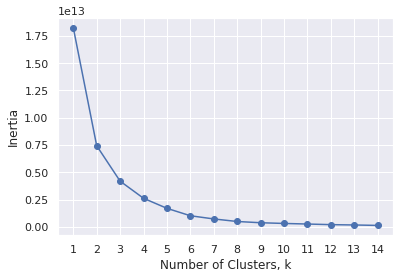

In [263]:
plt.plot(list(inertias.keys()), 
         list(inertias.values()), '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(list(inertias.keys()))
plt.show()

The optimal number of cluster according to the elbow method is about **4**.

In [305]:
clust_model = KMeans(n_clusters=4, init = 'k-means++')
clust_model.fit(X)
y_pred_cluster = clust_model.predict(X)

In [306]:
df_clust = dff.copy()
df_clust['Cluster'] = y_pred_cluster
df_clust.head(10)

,Edificación residencial,"Elaboración de azúcares, chocolates, dulces y similares","Conservación de frutas, verduras, guisos y otros alimentos preparados",Elaboración de productos lácteos,"Matanza, empacado y procesamiento de carne de ganado, aves y otros animales comestibles",Preparación y envasado de pescados y mariscos,Elaboración de productos de panadería y tortillas,Otras industrias alimentarias,Industria de las bebidas,Industria del tabaco,...,CP_78000,CP_80000,CP_83000,CP_86000,CP_87000,CP_90000,CP_91000,CP_97000,CP_98000,Cluster
State,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,122,28,15,190,17,0,728,71,136,0,...,0,0,0,0,0,0,0,0,0,0
Baja California,51,3,7,40,5,1,510,29,232,0,...,0,0,0,0,0,0,0,0,0,0
Baja California Sur,68,2,2,37,6,1,233,8,98,0,...,0,0,0,0,0,0,0,0,0,0
Campeche,40,10,1,21,4,2,276,27,49,0,...,0,0,0,0,0,0,0,0,0,0
Chiapas,126,9,16,35,28,1,930,40,376,0,...,0,0,0,0,0,0,0,0,0,2
Chihuahua,90,9,17,105,30,0,653,45,34,1,...,0,0,0,0,0,0,0,0,0,0
Coahuila,74,12,9,52,8,0,1007,34,44,0,...,0,0,0,0,0,0,0,0,0,0
Colima,80,9,4,43,2,0,214,17,35,0,...,0,0,0,0,0,0,0,0,0,0
Ciudad de México,55,13,5,74,6,0,514,21,95,0,...,0,0,0,0,0,0,0,0,0,1


In [266]:
Profiles = pd.pivot_table(df_clust, index='Cluster', aggfunc = 'mean')
Profiles

,"Actividades bursátiles, cambiarias y de inversión financiera",Asociaciones y organizaciones,Banca central,CP_21100,CP_23000,CP_24000,CP_25000,CP_28000,CP_29000,CP_31000,...,Servicios de mensajería y paquetería local,Servicios de preparación de alimentos y bebidas,Servicios inmobiliarios,Servicios médicos de consulta externa y servicios relacionados,"Servicios profesionales, científicos y técnicos",Target,Transporte aéreo regular,Transporte colectivo foráneo de pasajeros de ruta fija,Transporte colectivo urbano y suburbano de pasajeros de ruta fija,Transporte escolar y de personal
Cluster,,,,,,,,,,,,,,,,,,,,,
0,24.083333,525.75,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.000000,0.041667,...,1.750000,3495.541667,307.375000,1347.541667,830.208333,0.541667,2.666667,26.208333,20.458333,4.75
1,79.000000,741.00,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,7956.000000,651.000000,2760.000000,3143.000000,2.000000,30.000000,14.000000,31.000000,1.00
2,32.500000,892.50,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,...,6.833333,6730.333333,601.666667,2609.000000,1701.333333,0.166667,4.000000,43.000000,45.666667,4.50
3,7.000000,268.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2937.000000,149.000000,1153.000000,781.000000,0.000000,0.000000,24.000000,16.000000,1.00


In [273]:
Profiles['Profile'] = ['Incipient Veggie Area', 'Booming Veggie Area', 'Lagging Veggie Area', 'No Go Area']
Profiles[['Profile', 'Target']]

,Profile,Target
Cluster,,
0,Incipient Veggie Area,0.541667
1,Booming Veggie Area,2.000000
2,Lagging Veggie Area,0.166667
3,No Go Area,0.000000


In [307]:
# Profiling for each Zip Code (CP, in Spanish)
df_profiles = Profiles[['Profile']].reset_index()
df_CP_profiles = df.copy().reset_index()
df_CP_profiles['Cluster'] = y_pred_cluster
df_CP_profiles = df_CP_profiles.merge(df_profiles, how = 'left', left_on='Cluster', right_on = 'Cluster')
df_CP_profiles = df_CP_profiles[['State', 'CP', 'Cluster', 'Profile']]
df_CP_profiles

,State,CP,Cluster,Profile
0,Aguascalientes,20000,0,Incipient Veggie Area
1,Baja California,21100,0,Incipient Veggie Area
2,Baja California Sur,23000,0,Incipient Veggie Area
3,Campeche,24000,0,Incipient Veggie Area
4,Chiapas,29000,2,Lagging Veggie Area
5,Chihuahua,31000,0,Incipient Veggie Area
6,Coahuila,25000,0,Incipient Veggie Area
7,Colima,28000,0,Incipient Veggie Area
8,Ciudad de México,6000,1,Booming Veggie Area
9,Durango,34000,0,Incipient Veggie Area


#### **6.3 Lasso Regression**

In [327]:
# Using the clustering results in the Regression modeling
X = df_clust.drop(columns = 'Target').values
y = df_clust['Target'].values

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = 0.20)

In [329]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_s = scaler.transform(X)

In [330]:
regressor = Lasso(random_state=0)

In [331]:
params_grid = {'alpha': [100, 30, 10, 7, 6, 5, 4, 3, 2, 1, 0.8, 0.6, 0.5, 0.3, 0.1, 0.05, .01, 0.001],
              'max_iter': [10, 100, 1000, 10000],
              }

In [337]:
grid_lasso_search = GridSearchCV(estimator=regressor,
                               param_grid=params_grid,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               verbose = True,
                               cv=10,
                               refit=True, 
                               return_train_score=True)

In [338]:
%%time
grid_lasso_search.fit(X_train,y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
CPU times: user 687 ms, sys: 18.2 ms, total: 705 ms
Wall time: 1.65 s


GridSearchCV(cv=10, estimator=Lasso(random_state=0), n_jobs=-1,
             param_grid={'alpha': [100, 30, 10, 7, 6, 5, 4, 3, 2, 1, 0.8, 0.6,
                                   0.5, 0.3, 0.1, 0.05, 0.01, 0.001],
                         'max_iter': [10, 100, 1000, 10000]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=True)

In [339]:
grid_lasso_search.best_params_

{'alpha': 0.05, 'max_iter': 100}

In [340]:
grid_lasso_search.best_score_

-0.6572793127085614

In [342]:
# Final model
regressor = Lasso(alpha=0.05, max_iter = 100).fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f'R-squared: {metrics.r2_score(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')

R-squared: -0.4777782563063562
RMSE: 0.8855095922914146


In [344]:
regressor.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.06056187,  0.        ,  0.        ,  0.03082134,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.29061621,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.  

In [352]:
Features = pd.DataFrame(list(zip(df_clust.columns, regressor.coef_))).rename(columns = {0:'Feature', 1:'Coef'}).sort_values(by = 'Coef')
Features

,Feature,Coef
59,PIB2020,-0.290616
0,Edificación residencial,0.000000
69,CP_25000,0.000000
68,CP_24000,0.000000
67,CP_23000,-0.000000
...,...,...
25,"Comercio al por menor de mascotas, regalos, ar...",0.000000
96,CP_98000,-0.000000
34,Comercio al por menor exclusivamente a través ...,0.030821
31,Comercio al por menor de automóviles y camionetas,0.060562


### **7. Conclusions**


### **8. References**
- **INEGI (2018).** *Sistema de Clasificación Industrial de América del Norte 2018 (SCIAN 2018)*.  https://www.inegi.org.mx/app/scian/
- **INEGI (2020).** *Catálogo Único de Claves de Áreas Geoestadísticas Estatales, Municipales y Localidades*.  https://www.inegi.org.mx/app/ageeml/#
- **INEGI (2022).** *PIB por Entidad Federativa (PIBE). Base 2013*.  https://www.inegi.org.mx/programas/pibent/2013/#Tabulados